# Import Libraries

In [42]:
from src.sts import STSAnalyzer
from src.models import BaselineModel
import numpy as np
from nltk.metrics import jaccard_distance
import os
import pandas as pd
import re
# IMport partial
import nltk

from functools import partial
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk import ngrams
brown_ic = wordnet_ic.ic('ic-brown.dat')
from nltk import download
from nltk.stem import PorterStemmer

download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
# Load a spaCy model (supported languages are "es" and "en") 
nlp = spacy.load('en_core_web_sm')
# spaCy 3.x
nlp.add_pipe("spacy_wordnet", after='tagger')

import textdistance
from src.fe_utils import *

import textdistance
# prep_func = partial(spacy_preprocess_reviews, clean_func=clean_func, out_set=False)

INPUT_FOLDER = "input"
TRAIN_PATH = os.path.join(INPUT_FOLDER, "train")
TEST_PATH = os.path.join(INPUT_FOLDER, "test")
LS_FILES_TRAIN = ["MSRpar", "MSRvid", "SMTeuroparl"]
LS_FILES_TEST = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.SMTnews", "surprise.OnWN"]

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alberto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Used Functions

## Cleaning and Preprocessing

### Cleaning

During the course, different text cleaning and preprocessing techniques were introduced. In this section, we will use the functions that were introduced in the course to clean and preprocess the text data.

Our cleaning function will perform the following steps:

- Standardize time expressions converting hours in 24h format processing things like "8:30" and "8.30" as the same thing and converting "8am" to "8:00" and "8pm" to "20:00"
- Delete grammatic abbreviations such as "'s", "'d", "'ll", ... (note that n't is not removed because it has impact in the meaning)
- Delete mr., mrs., ms., ...
- Convert indexin symbols such as <.idx> into words
- Remove the points at the begining of a word
- Remove the "," of thousands to standardize numbers
- Transform percentages into unique symbol (e.g. 10 percent to 10_%)
- Remove dollar signs

In [ ]:
    
def clean_func(text):

    # Standardize the hours (1pm -> 13:00)
    def convert_to_24_hour(match):
        '''
        Function to convert time to 24 hour format
        Input: match - match object
        Output: string with the time in 24 hour format
        '''
        time_str = match.groups()
        hour, minute, am_pm = time_str[0], '' if time_str[1] is None else time_str[1] ,  re.sub('\.', '', '' if time_str[2] is None else time_str[2])
        # print(time_str)
        if am_pm == 'pm':
            if minute == '':
                return str(int(hour) + 12) + ':00'
            else:
                return str(int(hour) + 12) + ':' + minute
        elif am_pm == 'am':
            if hour == '12':
                return "00" + ':' + minute
            elif minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute
        else:
            if minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute

    hour_pattern_1 = re.compile(r'(?<=\s)(\d+)\s?()([ap]\.?m\.?)')
    hour_pattern_2 = re.compile(r'(\d+)[:\.](\d+)\s?([ap]\.?m\.?)')
    hour_pattern_3 = re.compile(r'(\d+)\s?[h:]\s?(\d+)\s?([ap]\.?m\.?)?')
    ls_patterns = [hour_pattern_1, hour_pattern_2, hour_pattern_3]
    for pat in ls_patterns:
        text = re.sub(pat, convert_to_24_hour, text)

    # Delete rests of abbreviated particles
    particle_pattern = re.compile(r"\b(?:'s|'d|'ll|'m|'re|'ve)\b", re.IGNORECASE)
    formatted_text = re.sub(particle_pattern, '', text)

    # Delete rests of abbreviated words to refer people
    mr_ms_pattern = re.compile(r"\b(mr.|mr|ms|ms.|mss.)\b", re.IGNORECASE)
    formatted_text = re.sub(mr_ms_pattern, '', formatted_text)

    # Convert indexes to a single word
    idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
    formatted_text = re.sub(idx_pattern, r'\1\2', formatted_text)
    
    # Remove the point from words starting with it
    start_point_pattern = re.compile(r'(\W)\.(\w+)', re.IGNORECASE)
    formatted_text = re.sub(start_point_pattern, r'\2', formatted_text)

    # Remove the comma from thousands (standardize)
    thousands_pattern = re.compile(r'(\d+),(\d+)', re.IGNORECASE)
    formatted_text = re.sub(thousands_pattern, r'\1\2', formatted_text)

    # Transform percentages to a single word
    percent_pattern = re.compile(r'(\d+)\s*per\s*cent', re.IGNORECASE)
    formatted_text = re.sub(percent_pattern, r'\1_%', formatted_text)
    
    # Remove the dollar sign from money
    money_pattern = re.compile(r'\$', re.IGNORECASE)
    formatted_text = re.sub(money_pattern, '' , formatted_text)
    
    # ls_removable_symbols = ['<', '>']
    # for symbol in ls_removable_symbols:
    #     formatted_text = formatted_text.replace(symbol, '')
        
    return formatted_text.lower()

### Preprocessing

Once the data is clean, preprocessing can be performed. In this case, we will use the following preprocessing steps:
- Tokenization
- Lemmatization
- Stopwords removal
- Punctuation removal

In [2]:
def spacy_preprocess_reviews(text, out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    if clean_func is not None:
        text = clean_func(text)

    doc = nlp(text)
    ls_processed_text = [w.lemma_ for w in doc if not w.is_stop and not w.is_punct]
    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text

# Load Data

The following data is provided for the training set:

- MSR-Paraphrase, Microsoft Research Paraphrase Corpus
  http://research.microsoft.com/en-us/downloads/607d14d9-20cd-47e3-85bc-a2f65cd28042/
  750 pairs of sentences.

- MSR-Video, Microsoft Research Video Description Corpus
  http://research.microsoft.com/en-us/downloads/38cf15fd-b8df-477e-a4e4-a4680caa75af/
  750 pairs of sentences.

- SMTeuroparl: WMT2008 development dataset (Europarl section)
  http://www.statmt.org/wmt08/shared-evaluation-task.html
  459 pairs of sentences.

In addition, it contains two surprise datasets comprising the
following collections:

- SMTnews: news conversation sentence pairs from WMT
  399 pairs of sentences.

- OnWN: pairs of sentences where the first comes from Ontonotes and
  the second from a WordNet definition.
  750 pairs of sentences.


In [5]:
def read_file(input_path, filename):
    '''
        Read the file and return a dataframe with the sentences and the gold standard
    '''
    dt = pd.read_csv(os.path.join(input_path, 'STS.input.' + filename + '.txt'), 
                        sep='\t|\\t', header=None, on_bad_lines='skip', engine='python')
    dt['gs'] = pd.read_csv(os.path.join(input_path, 'STS.gs.' + filename + '.txt'), 
                            sep='\t|\\t',header=None, on_bad_lines='skip', engine='python')
    dt.columns = ['sent1', 'sent2', 'gs']
    return dt

    
def load_data(input_path, ls_files):
    '''
    Load the data from the files

    If no files are specified, the initialization files are used
    '''

    if ls_files is None:
        ls_files = ls_files

    data = pd.DataFrame()
    for file in ls_files:
        data_file = read_file(input_path, file)
        data_file['file'] = file
        data = pd.concat([data, data_file], axis=0, ignore_index=True)
    
    return data

In [12]:
INPUT_PATH = "input"
LS_FILES_TRAIN = ["MSRpar", "MSRvid", "SMTeuroparl"]
LS_FILES_TEST = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.SMTnews", "surprise.OnWN"]

df_train = load_data(INPUT_PATH + "/train", LS_FILES_TRAIN)
df_test = load_data(INPUT_PATH + "/test", LS_FILES_TEST)

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (2234, 4)
Test data shape:  (3108, 4)


In [13]:
df_train.head()

,sent1,sent2,gs,file
0,But other sources close to the sale said Viven...,But other sources close to the sale said Viven...,4.00,MSRpar
1,Micron has declared its first quarterly profit...,Micron's numbers also marked the first quarter...,3.75,MSRpar
2,The fines are part of failed Republican effort...,"Perry said he backs the Senate's efforts, incl...",2.80,MSRpar
3,"The American Anglican Council, which represent...","The American Anglican Council, which represent...",3.40,MSRpar
4,The tech-loaded Nasdaq composite rose 20.96 po...,The technology-laced Nasdaq Composite Index <....,2.40,MSRpar


In [14]:
df_test.head()

,sent1,sent2,gs,file
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,MSRpar
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,MSRpar
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6,MSRpar
3,SEC Chairman William Donaldson said there is a...,"""I think there's a building confidence that th...",3.4,MSRpar
4,Vivendi shares closed 1.9 percent at 15.80 eur...,"In New York, Vivendi shares were 1.4 percent d...",1.4,MSRpar


## Analize the distribution of the data

The distribution of the similarity scores is shown in the following figure. As we can see, the distribution of the different datasets in train are really different.

- **MSRpar**: The distribution is similar to a skewed normal distribution with a mean of 3.32 and a standard deviation of 0.93. The distribution is not symmetric and has a long tail to the left. Q1 is 2.8 and Q3 is 4.0 so the 50% of data is between these two values. The minimum value is 0.25 and the maximum value is 5.0.
- **MSRvid**: The distribution in this case is not normal. The sparsity of the values is high and the distribution is not symmetric. The mean is 2.15 and the standard deviation is 1.60. Q1 is 0.6 and Q3 is 3.5 so the 50% of data is between these two values. The minimum value is 0.0 and the maximum value is 5.0. There are a significant number of values with a similarity score between 0 and 1.
- **SMTeuroparl**: In this case we have an accumulation of values in the range 4-5. This makes sense as the sentences are translations of each other.

**These differences in the distributions suggest that individual models should be trained for each dataset.**

In the case of the surprise datasets, the distributions are similar to the SMTeuroparl dataset.

In [24]:
df_train.groupby('file').describe()

gs                                              
             count      mean       std   min  25%  50%  75%  max
file                                                            
MSRpar       750.0  3.322064  0.929387  0.25  2.8  3.4  4.0  5.0
MSRvid       750.0  2.135317  1.595120  0.00  0.6  2.0  3.5  5.0
SMTeuroparl  734.0  4.307262  0.711437  0.00  4.0  4.4  4.8  5.0

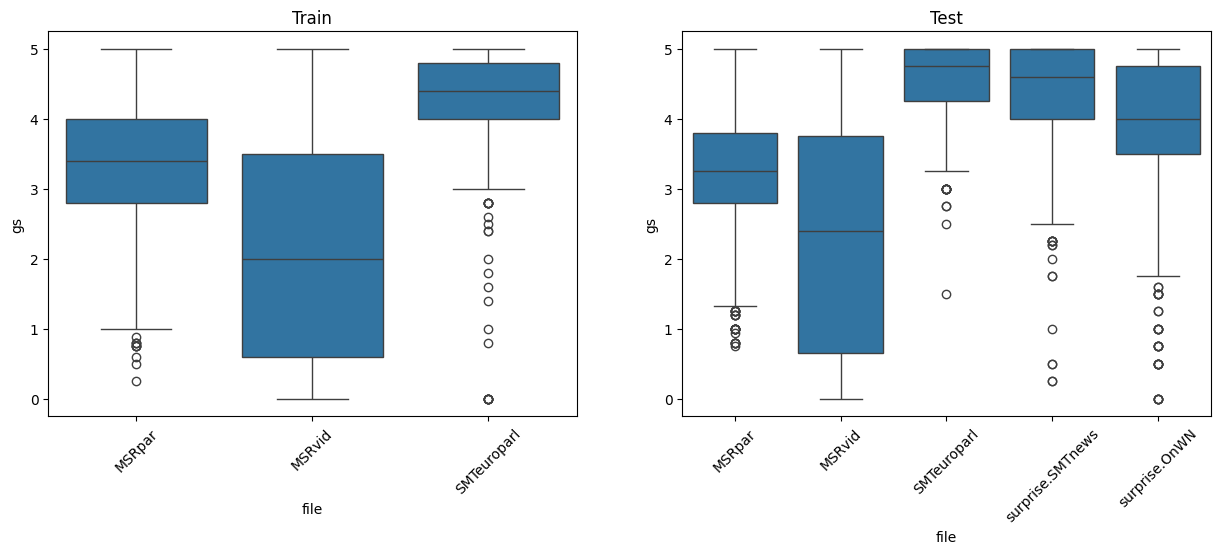

In [21]:
# Plot the distribution of the gold standard in the train and test sets for each of the files
import matplotlib.pyplot as plt
import seaborn as sns

# create subplots of boxplots for train and test
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# plot boxplots for train
sns.boxplot(x="file", y="gs", data=df_train, ax=axes[0])
# plot boxplots for test
sns.boxplot(x="file", y="gs", data=df_test, ax=axes[1])
# set title
axes[0].set_title("Train")
axes[1].set_title("Test")

# Rotate x-axis labels
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
# display plot
plt.show()


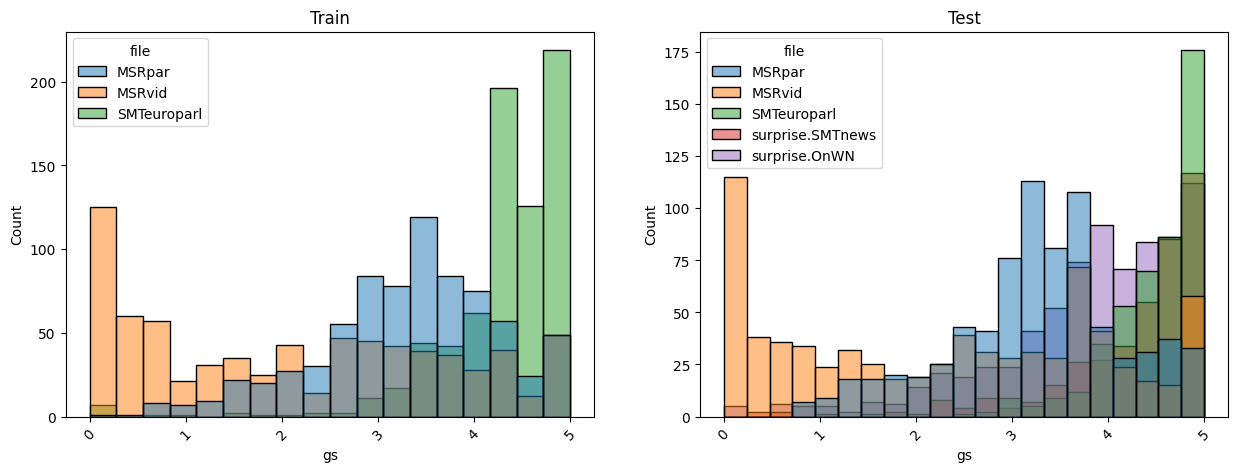

In [23]:
# Plot the histogram of the gold standard in the train and test sets for each of the files
import matplotlib.pyplot as plt
import seaborn as sns

# create subplots of boxplots for train and test hue file
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# plot boxplots for train
sns.histplot(x="gs", data=df_train, hue="file", ax=axes[0])
# plot boxplots for test
sns.histplot(x="gs", data=df_test, hue="file", ax=axes[1])
# set title
axes[0].set_title("Train")
axes[1].set_title("Test")

# Rotate x-axis labels
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
# display plot
plt.show()

# Build Features

The following features will be used to train the model:

**Text Comparison**
- String similarity features: 
   - **Longest Common Substring (`lcstr`):**
      - This measure calculates the length of the longest common substring shared between two strings. A substring is a contiguous sequence of characters that appears in both strings.
   - **Longest Common Subsequence (`lcseq`):**
      - This measure computes the length of the longest common subsequence between two strings. A subsequence is not necessarily contiguous, but it preserves the order of characters.
   - **Greedy String Tiling (`gst`):**
      - Greedy String Tiling measures similarity based on the length of the longest common substrings, allowing for overlaps. It identifies common substrings between two strings in a way that maximizes coverage.
   - **Jaro Similarity (`jaro`):**
      - Jaro similarity is a measure of similarity between two strings. It considers the number of matching characters and the transpositions (swaps) of characters. The result is normalized to a value between 0 and 1.
   - **Jaro-Winkler Similarity (`jaro_w`):**
      - Jaro-Winkler is an extension of Jaro similarity that gives extra weight to common prefixes. It is particularly useful when comparing strings that are expected to share a common prefix.
   - **Monge-Elkan Similarity (`monge`):**
      - Monge-Elkan similarity is based on the similarity of token sets. It calculates a similarity score by comparing the tokens of the two strings. This can be useful when comparing strings with different tokenizations.
   - **Levenshtein Distance (`levenshtein`):**
      - Levenshtein distance measures the minimum number of single-character edits (insertions, deletions, or substitutions) required to transform one string into another. The distance is inversely related to similarity.

- N-Gram similarity features: For N-grams from 1 to 5 (choice based on \[1\]). 3 different tokenizations are used: nltk WordNet tokenizer, Spacy lemmas and Spacy+Porter-Stemmer (best performing one during the labs.) the following features will be used:
   - **Jaccard similarity (`jaccard`):**
      - Jaccard similarity is a measure of similarity between two sets. It is defined as the size of the intersection divided by the size of the union of the two sets.
   - **Dice similarity (`dice`):**
      - Dice similarity is a measure of similarity between two sets. It is defined as twice the size of the intersection divided by the sum of the sizes of the two sets.
    - **Overlap coefficient (`overlap`):**
      - Overlap coefficient is a measure of similarity between two sets. It is defined as the size of the intersection divided by the size of the smaller set.
    - **Cosine similarity (`cosine`):**
      - Cosine similarity is a measure of similarity between two vectors. It is defined as the dot product of the two vectors divided by the product of their magnitudes.

**Semantic Comparison**
- Semantic similarity features: For each word in each sentence, it list of synsets is calculated. After that, the similarity measure for each word in sentence 1 with respect to sentence 2 is calculated using *the maximum of the similarities of its synsets with respect to those corresponding to sentence 2**. Given that similarity measures can be asymetric as in the case of Wu-Palmer, it is calculated in both directions and then averaged.
  - **Path similarity (`path`):**
    - Path similarity is a measure of similarity between two synsets. It is defined as the length of the shortest path between the two synsets in the hypernym hierarchy.
  - **Wu-Palmer Similarity (`wup`):**
    - Wu-Palmer similarity is a measure of similarity between two synsets. It is defined as the depth of the two synsets in the hypernym hierarchy divided by the depth of their least common subsumer.
  - **Leacock-Chodorow Similarity (`lch`):**
    - Leacock-Chodorow similarity is a measure of similarity between two synsets. It is defined as -log(p/2d) where p is the shortest path length between the two synsets and d is the maximum depth of the taxonomy.
   - **Lin Similarity (`lin`):**
     - Lin similarity is a measure of similarity between two synsets. It is defined as 2log(p/(p1+p2)) where p is the shortest path length between the two synsets, p1 is the shortest path length from the first synset to the root, and p2 is the shortest path length from the second synset to the root.

**Structure Comparison**
- Stopwords similarity features: n-gram similarity features are calculated using only stopwords.


In [36]:
############### AUXILIARY FUNCTIONS #####################

def dice_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    try:
        return 2*len(x_n_y) / (len(x) + len(y))
    except ZeroDivisionError:
        return 0

def overlap_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    try:
        return len(x_n_y) / min(len(x), len(y))
    except ZeroDivisionError:
        return 0

def cosine_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)

    if len(x_n_y) == 0:
        return 0
    
    try:
        return len(x_n_y) / np.sqrt(len(x)*len(y))
    except ZeroDivisionError:
        return 0

def jaccard_sim(x, y):
    '''
    Get the Jaccard similarity between two sets
    '''
    x = set(x)
    y = set(y)
    try:
        return 1 - jaccard_distance(x, y)
    except ZeroDivisionError:
        return 0


def get_similarities(X, d_sim=None):
    '''
    Get the similarities between two sentences
    '''
    df_sim = pd.DataFrame()
    if d_sim is None:
        d_sim = {"jaccard": jaccard_sim, "dice": dice_sim, 
                  "overlap": overlap_sim, "cosine": cosine_sim}
        
    for name, sim in d_sim.items():
        df_sim[name] = X.apply(lambda x: sim(x["sent1"], x["sent2"]), axis=1)
        
    return df_sim


def get_path_similarity(syn1, syn2):
    return syn1.path_similarity(syn2)

def get_lch_similarity(syn1, syn2):
    try:
        return syn1.lch_similarity(syn2)
    except:
        return None
    
def get_wup_similarity(syn1, syn2):
    try:
        return syn1.wup_similarity(syn2)
    except:
        return None
    
def get_lin_similarity(syn1, syn2):
    try:
        return syn1.lin_similarity(syn2, brown_ic)
    except:
        return None
    
def longest_common_substring(str1, str2):
    return textdistance.lcsstr.similarity(str1, str2)

def longest_common_subsequence(str1, str2):
    return textdistance.lcsseq.similarity(str1, str2)

def greedy_string_tiling(str1, str2):
    return textdistance.ratcliff_obershelp.similarity(str1, str2)

def jaro_similarity(str1, str2):
    return textdistance.jaro.similarity(str1, str2)  # Use jellyfish for Jaro similarity

def jaro_winkler_similarity(str1, str2):
    return textdistance.jaro_winkler.similarity(str1, str2)

def monge_elkan_similarity(str1, str2):
    return textdistance.monge_elkan.similarity(str1, str2)

def levenshtein_distance(str1, str2):
    return textdistance.levenshtein.similarity(str1, str2)


def get_textdistance_similarities(X, d_sim=None):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"lcstr": longest_common_substring, "lcseq": longest_common_subsequence, 
                  "gst": greedy_string_tiling, "jaro": jaro_similarity, 
                  "jaro_w": jaro_winkler_similarity, "monge": monge_elkan_similarity, 
                  "levenshtein": levenshtein_distance}

    df_sim = pd.DataFrame()
    for name, sim in d_sim.items():
        df_sim[name] = X.apply(lambda x: sim(x["sent1"], x["sent2"]), axis=1)

    return df_sim

def get_word_ngrams(text, n, tokenize=True):
    if tokenize:
        words = nltk.word_tokenize(text)
    else:
        words = text
    return list(ngrams(words, n))

def get_ngrams_similarity(x, y, sim, n=2, tokenize=True):
    ngrams1 = get_word_ngrams(x, n, tokenize=tokenize)
    ngrams2 = get_word_ngrams(y, n, tokenize=tokenize)
    return sim(ngrams1, ngrams2)

def get_ngrams_similarities(X, d_sim=None, nmax=5, tokenize=True):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"jaccard": jaccard_sim, "dice": dice_sim, 
                  "overlap": overlap_sim, "cosine": cosine_sim}

    df_sim = pd.DataFrame()
    for n in range(1, nmax+1):
        for name, sim in d_sim.items():
            df_sim[name + f"_n_{n}"] = X.apply(lambda x: get_ngrams_similarity(x["sent1"], x["sent2"], sim, n=n, tokenize=tokenize), axis=1)
        
    return df_sim

def calculate_idf(term, documents):
    document_frequency = sum(1 for document in documents if term in document)
    if document_frequency == 0:
        return 0.0
    else:
        return np.log(len(documents) / document_frequency)
    
def compare_synsets(ls_ls_syns1, ls_ls_syns2, documents=None, similarity=get_wup_similarity, idf=True):

    d_out = {}
    for w, ls_syns1 in ls_ls_syns1:
        d_out[w] = []
        for _, ls_syns2 in ls_ls_syns2:
            for syn1 in ls_syns1:
                for syn2 in ls_syns2:
                    out = similarity(syn1, syn2) if syn1.pos() == syn2.pos() else 0
                    out = 0 if out is None else out
                    d_out[w].append(out)
                    # print(syn1, syn2, out)
        
        if d_out[w] != []:
            if idf:
                d_out[w] = calculate_idf(w, documents) * np.max(d_out[w])
            else:
                d_out[w] = np.max(d_out[w])
        else:
            d_out[w] = 0

    return d_out

def get_sem_similarities(X, d_sim=None, idf=True, documents=None):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"wup": get_wup_similarity, "path": get_path_similarity, 
                  "lch": get_lch_similarity, "lin": get_lin_similarity}

    df_sim = pd.DataFrame()
    for name, sim in d_sim.items():
        if idf:
            sim_fw = X.apply(lambda x: sum(compare_synsets(x.iloc[0], x.iloc[1], documents, similarity=sim).values()), axis=1)
            sim_bw = X.apply(lambda x: sum(compare_synsets(x.iloc[1], x.iloc[0], documents, similarity=sim).values()), axis=1)
        else:
            sim_fw = X.apply(lambda x: sum(compare_synsets(x.iloc[0], x.iloc[1], idf=idf, similarity=sim).values()), axis=1)
            sim_bw = X.apply(lambda x: sum(compare_synsets(x.iloc[1], x.iloc[0], idf=idf, similarity=sim).values()), axis=1)
        
        df_sim[name] = (sim_fw + sim_bw) / 2

    return df_sim


def apply_lesk_algorithm(nlp_sentence):
    '''
    Apply the Lesk algorithm to a sentence
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    spacy_to_wordnet_pos = {
        "ADJ": "a",    # Adjective
        "NOUN": "n",   # Noun
        "PROPN": "n",  # Proper noun
        "VERB": "v",   # Verb
        "ADV": "r",    # Adverb
        "NUM": "n",    # Numeral
        "PRON": "n",   # Pronoun
        "ADP": "n",    # Adposition (preposition or postposition)
    }

    
    # Get the POS tag
    ls_postagged_lemmas = [(w.lemma_.lower(), w.pos_) for w in nlp_sentence 
                            if not w.is_stop and not w.is_punct]

    # Convert the POS tag to the WordNet POS tag
    ls_postagged_lemmas = [(lemma, spacy_to_wordnet_pos.get(pos)) 
                         for lemma, pos in ls_postagged_lemmas]
    
    # Instead of using the original text for disambiguation, we use only the lemmas
    text = ' '.join([lemma for lemma, _ in ls_postagged_lemmas])

    disamb_set = set()
    for lemma, pos in ls_postagged_lemmas:
        # If it has a disambiguation synset, get it
        get_disamb = nltk.wsd.lesk(text, lemma, pos)

        # Otherwise, get the first synset
        if get_disamb is None:
            try:
                get_disamb = wn.synsets(lemma, pos)[0].name()
            except IndexError:
                get_disamb = lemma
        # If there isn't a first sentence, get the lemma
        else:
            get_disamb = get_disamb.name()

        disamb_set.add(get_disamb)
        
    return disamb_set


def apply_lesk_algorithm_and_return_synset(nlp_sentence):
    '''
    Apply the Lesk algorithm to a sentence
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    spacy_to_wordnet_pos = {
        "ADJ": "a",    # Adjective
        "NOUN": "n",   # Noun
        "PROPN": "n",  # Proper noun
        "VERB": "v",   # Verb
        "ADV": "r",    # Adverb
        "NUM": "n",    # Numeral
        "PRON": "n",   # Pronoun
        "ADP": "n",    # Adposition (preposition or postposition)
    }

    
    # Get the POS tag
    ls_postagged_lemmas = [(w.lemma_.lower(), w.pos_) for w in nlp_sentence 
                            if not w.is_stop and not w.is_punct]

    # Convert the POS tag to the WordNet POS tag
    ls_postagged_lemmas = [(lemma, spacy_to_wordnet_pos.get(pos)) 
                         for lemma, pos in ls_postagged_lemmas]
    
    # Instead of using the original text for disambiguation, we use only the lemmas
    text = ' '.join([lemma for lemma, _ in ls_postagged_lemmas])

    disamb_set = set()
    for lemma, pos in ls_postagged_lemmas:
        # If it has a disambiguation synset, get it
        get_disamb = nltk.wsd.lesk(text, lemma, pos)

        # Otherwise, get the first synset
        if get_disamb is None:
            try:
                get_disamb = wn.synsets(lemma, pos)[0]
            except IndexError:
                get_disamb = lemma
        # If there isn't a first sentence, get the lemma
        else:
            get_disamb = get_disamb

        disamb_set.add(get_disamb)
        
    return disamb_set

In [39]:

class FeatureExtractor:
    def __init__(self, prep_func=prep_func, clean_func=clean_func):
        self.prep_func = prep_func
        self.clean_func = clean_func
                 
    def fit_transform(self, df, documents=None):

        prep_func = self.prep_func
        clean_func = self.clean_func

        print("Building auxiliary dataframes...")
        ## BUILD NECESSARY DATAFRAMES
        # Preprocess using spacy and clean and return lists
        print("- Tokenized (list)")
        df_prep_ls = df[["sent1", "sent2"]].copy()
        df_prep_ls["sent1"] = df_prep_ls["sent1"].apply(lambda x: prep_func(x, out_set=False))
        df_prep_ls["sent2"] = df_prep_ls["sent2"].apply(lambda x: prep_func(x, out_set=False))
        
        print("- Tokenized (set)")
        # Preprocess using spacy and clean and return sets
        df_prep = df_prep_ls.copy()
        df_prep["sent1"] = df_prep["sent1"].apply(lambda x: set(x))
        df_prep["sent2"] = df_prep["sent2"].apply(lambda x: set(x))
        
        print("- Clean Strings")
        # Clean and return strings
        df_clean = df[["sent1", "sent2"]].copy()
        df_clean["sent1"] = df_clean["sent1"].apply(lambda x: clean_func(x))
        df_clean["sent2"] = df_clean["sent2"].apply(lambda x: clean_func(x))

        print("- Synsets")
        # Get synsets for each token
        df_synsets = df[['sent1', 'sent2']].copy()
        df_synsets = df_synsets.map(lambda x: [(token.text, token._.wordnet.synsets()) for token in nlp(x)
                                                if not token.is_stop and not token.is_punct 
                                                and not token.is_space])
        
        print("- Stopwords")
        df_stops = df_clean[["sent1", "sent2"]].copy()
        df_stops["sent1"] = df_stops["sent1"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])
        df_stops["sent2"] = df_stops["sent2"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])

        print("- Porter Stemmer")
        df_stem = df_prep[["sent1", "sent2"]].copy()
        df_stem = df_stem.map(lambda x: {PorterStemmer().stem(xx) for xx in x})

        print("\n")
        print("Building features...")
        ## BUILD FEATURES

        # df_features = pd.DataFrame(df["file"].values, columns=["file"])
        df_features = pd.DataFrame()

        print("- String Similarities")
        # Get String Similarities (df_clean strings)
        df_textdistance = get_textdistance_similarities(df_clean)
        if len(df_features.columns.intersection(df_textdistance.columns)) == 0:
            df_features = pd.concat([df_features, df_textdistance], axis=1)

        print("- N-Grams Similarities")
        # Get N-Grams Similarities (df_clean strings)
        
        print("---- Use wordnet as a tokenizer")
        # ---- Use wordnet as a tokenizer
        df_ngram_sim = get_ngrams_similarities(df_clean)

        if len(df_features.columns.intersection(df_ngram_sim.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_sim], axis=1)
        
        print("---- Use spacy preprocessed as a tokenizer")
        # ---- Use spacy preprocessed data as tokens
        df_ngram_sim_spacy = get_ngrams_similarities(df_prep_ls, tokenize=False)
        df_ngram_sim_spacy.columns = [col + "_spacy" for col in df_ngram_sim_spacy.columns]

        if len(df_features.columns.intersection(df_ngram_sim_spacy.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_sim_spacy], axis=1)

        print("---- Porter Stemmer")
        # Get ngram distances for Porter Stemmer
        df_ngram_stem = get_ngrams_similarities(df_stem, tokenize=False)
        df_ngram_stem.columns = [col + "_stem" for col in df_ngram_stem.columns]

        if len(df_features.columns.intersection(df_ngram_stem.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_stem], axis=1)

        # Get Wordnet Similarities (df_synsets)
        
        print("- Wordnet Semantic Similarities")
        # These are the documents to calculate the idf. In case of train, we don't have
        # to provide it, since it will be calculated from the train data. In case of test,
        # we have to provide it, since we don't have the train data.
        
        if documents is None:
            print("---- IDF Calculation")
            documents = df_prep["sent1"].tolist() + df_prep["sent2"].tolist()

        # print("---- IDF Weighted")
        # # Calculate similarities, weight them with idf and average forward and backwards
        # # this is mainly for asymetric similarities like Wu Palmer
        # df_sem_sim = get_sem_similarities(df_synsets, idf=True, documents=documents)
        # df_sem_sim.columns = [col + "_idf" for col in df_sem_sim.columns]
    
        # if len(df_sem_sim.columns.intersection(df_features.columns)) == 0:
        #     df_features = pd.concat([df_features, df_sem_sim], axis=1)

        print("---- NON IDF Weighted")
        # Do the same without idf
        df_sem_sim_not_idf = get_sem_similarities(df_synsets, idf=False)
        if len(df_features.columns.intersection(df_sem_sim_not_idf.columns)) == 0:
            df_features = pd.concat([df_features, df_sem_sim_not_idf], axis=1)

        print("- Word dismambiguation")
        df_wd = df_clean[['sent1', 'sent2']].copy()
        df_wd["sent1"] = df_wd["sent1"].apply(lambda x: apply_lesk_algorithm(nlp(x)))
        df_wd["sent2"] = df_wd["sent2"].apply(lambda x: apply_lesk_algorithm(nlp(x)))

        print("- Word dismambiguation Semantic")
        df_wd_s = df_clean[['sent1', 'sent2']].copy()
        df_wd_s["sent1"] = df_wd_s["sent1"].apply(lambda x: apply_lesk_algorithm_and_return_synset(nlp(x)))
        df_wd_s["sent2"] = df_wd_s["sent2"].apply(lambda x: apply_lesk_algorithm_and_return_synset(nlp(x)))

        print("---- Similarity Stopwords")
        df_ngram_stop = get_ngrams_similarities(df_stops, tokenize=False)
        df_ngram_stop.columns = [col + "_stop" for col in df_ngram_stop.columns]
        
        if len(df_features.columns.intersection(df_ngram_stop.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_stop], axis=1)

        # self.documents = documents
        return df_features
    
    def transform(self, df):
        #return self.fit(df, documents=self.documents)
        return self.fit_transform(df)
        
    

In [43]:
prep_func = partial(spacy_preprocess_reviews, clean_func=clean_func, out_set=False)

df_train_sample = df_train.sample(30, random_state=42)
df_test_sample = df_test.sample(20, random_state=42)

fe = FeatureExtractor()
X_train_sample = fe.fit_transform(df_train_sample)
X_test_sample = fe.transform(df_test_sample)

Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
---- Porter Stemmer
- Wordnet Semantic Similarities
---- IDF Calculation
---- NON IDF Weighted
- Word dismambiguation
- Word dismambiguation Semantic
---- Similarity Stopwords
Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
---- Porter Stemmer
- Wordnet Semantic Similarities
---- IDF Calculation
---- NON IDF Weighted
- Word dismambiguation
- Word dismambiguation Semantic
---- Similarity Stopwords


In [44]:
X_train_sample

,lcstr,lcseq,gst,jaro,jaro_w,monge,levenshtein,jaccard_n_1,dice_n_1,overlap_n_1,cosine_n_1,jaccard_n_2,dice_n_2,overlap_n_2,cosine_n_2,jaccard_n_3,dice_n_3,overlap_n_3,cosine_n_3,jaccard_n_4,dice_n_4,overlap_n_4,cosine_n_4,jaccard_n_5,dice_n_5,overlap_n_5,cosine_n_5,jaccard_n_1_spacy,dice_n_1_spacy,overlap_n_1_spacy,cosine_n_1_spacy,jaccard_n_2_spacy,dice_n_2_spacy,overlap_n_2_spacy,cosine_n_2_spacy,jaccard_n_3_spacy,dice_n_3_spacy,overlap_n_3_spacy,cosine_n_3_spacy,jaccard_n_4_spacy,dice_n_4_spacy,overlap_n_4_spacy,cosine_n_4_spacy,jaccard_n_5_spacy,dice_n_5_spacy,overlap_n_5_spacy,cosine_n_5_spacy,jaccard_n_1_stem,dice_n_1_stem,overlap_n_1_stem,cosine_n_1_stem,jaccard_n_2_stem,dice_n_2_stem,overlap_n_2_stem,cosine_n_2_stem,jaccard_n_3_stem,dice_n_3_stem,overlap_n_3_stem,cosine_n_3_stem,jaccard_n_4_stem,dice_n_4_stem,overlap_n_4_stem,cosine_n_4_stem,jaccard_n_5_stem,dice_n_5_stem,overlap_n_5_stem,cosine_n_5_stem,wup,path,lch,lin,jaccard_n_1_stop,dice_n_1_stop,overlap_n_1_stop,cosine_n_1_stop,jaccard_n_2_stop,dice_n_2_stop,overlap_n_2_stop,cosine_n_2_stop,jaccard_n_3_stop,dice_n_3_stop,overlap_n_3_stop,cosine_n_3_stop,jaccard_n_4_stop,dice_n_4_stop,overlap_n_4_stop,cosine_n_4_stop,jaccard_n_5_stop,dice_n_5_stop,overlap_n_5_stop,cosine_n_5_stop
1034,21,26,0.732394,0.708645,0.766916,0.022161,26,0.500000,0.666667,0.714286,0.668153,0.250000,0.400000,0.428571,0.400892,0.181818,0.307692,0.333333,0.308607,0.100000,0.181818,0.200000,0.182574,0.000000,0.000000,0.000000,0.000000,0.166667,0.285714,0.333333,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.285714,0.333333,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.008333,1.933333,9.755584,2.833866,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
426,10,40,0.644628,0.747030,0.848218,0.017857,33,0.473684,0.642857,0.642857,0.642857,0.130435,0.230769,0.230769,0.230769,0.043478,0.083333,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.619048,4.229167,12.392083,3.501626,0.333333,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
482,45,87,0.523659,0.734388,0.734388,0.005523,53,0.350000,0.518519,0.560000,0.519947,0.173913,0.296296,0.320000,0.297113,0.130435,0.230769,0.250000,0.231455,0.086957,0.160000,0.173913,0.160514,0.066667,0.125000,0.136364,0.125436,0.291667,0.451613,0.466667,0.451848,0.160000,0.275862,0.285714,0.276026,0.080000,0.148148,0.153846,0.148250,0.041667,0.080000,0.083333,0.080064,0.000000,0.000000,0.000000,0.000000,0.291667,0.451613,0.466667,0.451848,0.074074,0.137931,0.142857,0.138013,0.038462,0.074074,0.076923,0.074125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.454212,9.029167,33.835002,8.690234,0.357143,0.526316,0.625000,0.533002,0.125000,0.222222,0.285714,0.227921,0.066667,0.125000,0.166667,0.129099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
755,13,25,0.892857,0.862665,0.917599,0.035665,25,0.714286,0.833333,0.833333,0.833333,0.428571,0.600000,0.600000,0.600000,0.142857,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.666667,0.666667,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000